<a href="https://colab.research.google.com/github/ijzm/ASL/blob/main/ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 32
img_height = 64
img_width = 64

data_dir = "/content/drive/MyDrive/TAC/TA/asl_alphabet_train/asl_alphabet_train"
#data_dir = r"D:\2021-1\DeepLearning\A-Notebooks\TA\asl_alphabet_train\asl_alphabet_train"


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


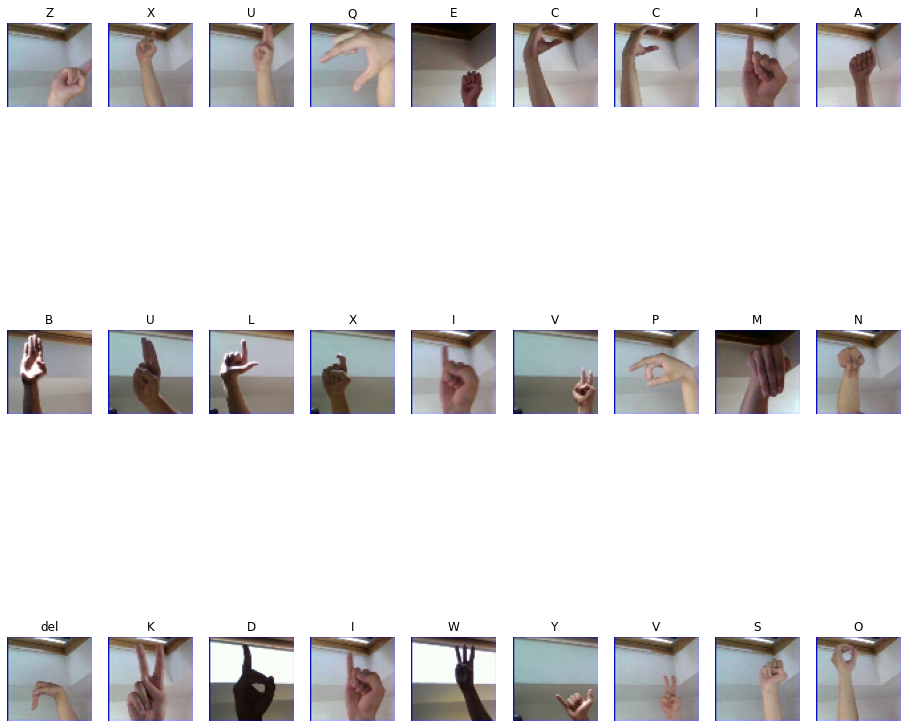

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

class_names = train_ds.class_names

num_columns = 9
num_rows = len(class_names) // num_columns

img_size = 16

plt.figure(figsize=(img_size, img_size))

for images, labels in train_ds.take(1):
  for i in range(num_columns * num_rows):
    ax = plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

# Preprocessing

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modelo

In [ ]:
def create_model():
    K.clear_session()
    model = Sequential([
        Rescaling(1./255),

        Conv2D(32, 3, activation='relu'),
        MaxPooling2D(),
        Conv2D(32, 3, activation='relu'),
        MaxPooling2D(),
        Conv2D(32, 3, activation='relu'),
        MaxPooling2D(),
        
        Flatten(),

        Dense(128, activation='relu'),

        #Output Layer
        Dense(len(class_names))
    ])
    return model

model = create_model()

# Entrenamiento

In [ ]:
initial_learning_rate = 0.0001

decay_steps = 100000 
decay_rate  = 0.96

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate
)

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0

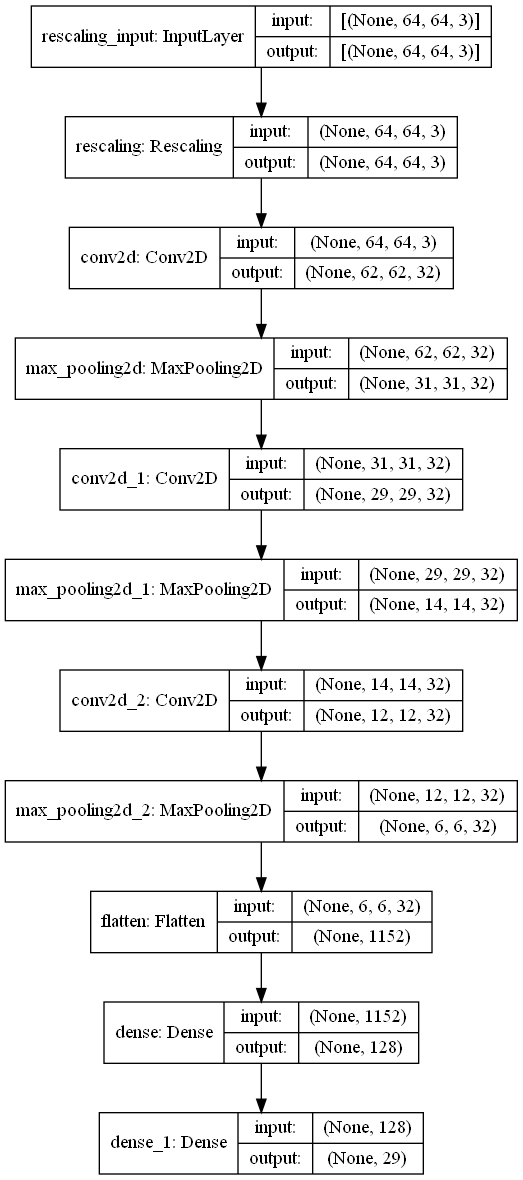

In [ ]:
plot_model(model, to_file="model.png", show_shapes=True)

In [ ]:
def show_results(log):
  val_loss = log.history['val_loss']
  val_acc = log.history['val_acc']
      
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes
  ax1.plot(log.history['loss'], label='train')
  ax1.plot(val_loss, label='test')
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  ax2.plot(log.history['acc'], label='train')
  ax2.plot(val_acc, label='test')
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  for ax in axes: ax.legend()

In [ ]:
epochs = 100

checkpoint = ModelCheckpoint(
    "model-epoch_{epoch:02d}-loss_{loss:.3f}-val_acc_{val_acc:.3f}-weights",
    monitor="val_acc",
    mode="max"
)

early_stopping = EarlyStopping(monitor="val_acc", patience=10, mode="max")

callbacks = [checkpoint, early_stopping] #No modificar esta línea

In [ ]:
log = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/100
2175/2175 [==============================] - 28s 13ms/step - loss: 0.1994 - acc: 0.9351 - val_loss: 0.1649 - val_acc: 0.9477
INFO:tensorflow:Assets written to: model-epoch_01-loss_0.153-val_acc_0.948-weights\assets
Epoch 2/100
2175/2175 [==============================] - 24s 11ms/step - loss: 0.0844 - acc: 0.9728 - val_loss: 0.0825 - val_acc: 0.9737
INFO:tensorflow:Assets written to: model-epoch_02-loss_0.076-val_acc_0.974-weights\assets
Epoch 3/100
2175/2175 [==============================] - 25s 11ms/step - loss: 0.0631 - acc: 0.9799 - val_loss: 0.0727 - val_acc: 0.9782
INFO:tensorflow:Assets written to: model-epoch_03-loss_0.052-val_acc_0.978-weights\assets
Epoch 4/100
2175/2175 [==============================] - 24s 11ms/step - loss: 0.0480 - acc: 0.9853 - val_loss: 0.0362 - val_acc: 0.9890
INFO:tensorflow:Assets written to: model-epoch_04-loss_0.041-val_acc_0.989-weights\assets
Epoch 5/100
2175/2175 [==============================] - 23s 11ms/step - loss: 0.0359 - acc:

# Validacion

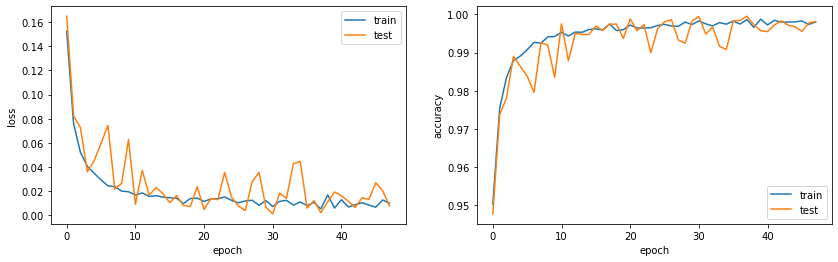

In [ ]:
show_results(log)

In [ ]:
test_dir = r"D:\2021-1\DeepLearning\A-Notebooks\TA\asl_alphabet_test\asl_alphabet_test"
    
for file in os.listdir(test_dir):
     filename = os.fsdecode(file)
     if filename.endswith(".jpg"): 
        filepath = os.path.join(test_dir, filename)
         
        img = tf.keras.preprocessing.image.load_img(
            filepath,
            target_size=(img_height, img_width)
        )

        img_array = tf.keras.preprocessing.image.img_to_array(img)

        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(
            img_array,
            use_multiprocessing=True
        )

        print(filename, end=" - ")
        print(np.argmax(predictions), end=" - ")
        print(class_names[np.argmax(predictions)])



# Resultados

In [ ]:
model.built = True 
checkpoint_path  = r"D:\2021-1\DeepLearning\A-Notebooks\model-epoch_48-loss_0.010-val_acc_0.998-weights"
#model.load_weights(checkpoint_path)

model = tf.keras.models.load_model(checkpoint_path)

#loss, acc = model.evaluate(test_images, test_labels, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


In [ ]:
import PIL

def Predict_Image(filepath):

    img = tf.keras.preprocessing.image.load_img(
        filepath,
        target_size=(img_height, img_width)
    )

    img_array = tf.keras.preprocessing.image.img_to_array(img)

    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(
        img_array,
        use_multiprocessing=True
    )

    title = """
        Filename: {FILENAME}
        Best Prediction: {BESTPRED}
        Best Score: {BESTSCORE:.2f}
    """

    BestPred = np.argmax(predictions)

    filename = os.path.basename(filepath)

    print(predictions[0])

    plt.figure(figsize=(4, 4))
    img = PIL.Image.open(filepath)
    plt.imshow(img)
    plt.title(title.format(
        FILENAME = filename,
        BESTPRED = class_names[BestPred],
        BESTSCORE = predictions[0][BestPred]
    ), {
        "fontsize": 32,
        "color": "black",
    })
    plt.axis("off")

[-125.91696    -92.23562   -152.11443    -73.78078    -69.20865
   72.28051    -51.073956   -71.1748      -3.9604735  -21.751795
  -40.214615   -90.0026    -123.47987    -61.169224    -6.486979
    7.7942853  -74.65125   -205.95656    -76.04973    -62.501076
 -254.46255   -127.85972    -45.564266  -109.93123     26.81971
 -144.91385    -65.96385   -177.4385      44.526962 ]


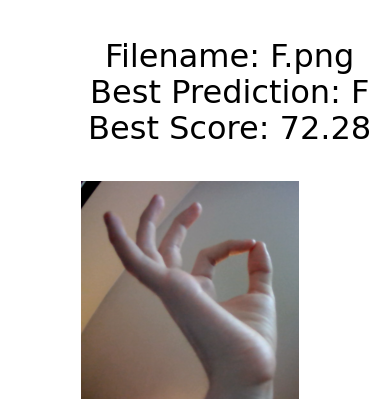

In [ ]:
dirname = r"D:\2021-1\DeepLearning\A-Notebooks\TA\ijzm"

Predict_Image(dirname + r"\F.png")
